In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/Robert_Bosch/dataset/Test_data/
# %ls 
# # %mkdir -p dataset
# !pip install ipdb
# # !unzip Test_data.zip -d dataset

In [3]:
%ls

'eff-ns-b7_focal[Training].ipynb'   Robet_Bosch_Viper-Triplet.ipynb   Val/
 lightning_logs/                    Sample_Submission.csv             weights/
 Robet_Bosch_Viper-Eff.ipynb        Test/
 Robet_Bosch_Viper.ipynb            Train/


In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipdb 
import pandas as pd
import os
os.chdir('./')
train_test_val = 0
dataset = []
k_fold = True
folders_to_look = ['Train/','Val/'] if k_fold==True else ['Train/']
classes = [cl.split('/')[1] for cl in glob.glob('Train/'+'/*')] #Class names
cls_len = len(glob.glob('Train/'+'/*')) #Number of Classes in the dataset

for folder in glob.iglob('*/'):
    if(train_test_val == 0):
        if(folder in folders_to_look):
            for classess in glob.glob(folder+'/*'):
                for files in glob.iglob(classess+"/*.jpg"):
                    img_path = files
                    class_id = classes.index(files.split('/')[1])
                    dataset.append((img_path,class_id))

df = pd.DataFrame(dataset,columns=['image_path','class'])
# dataset = np.asarray(dataset)
train_df, val_df = df.iloc[:970],df.iloc[970:]
print("Data Points:")
print("Train:",len(train_df),"Test:",len(val_df))


#Checking for Class Imbalance
cls, counts = np.unique(train_df['class'].values, return_counts=True)
# print([print("class:",classes[cls[i]],"counts:",counts[i]) for i in range(cls_len)])
# Hence no class imbalance


Data Points:
Train: 970 Test: 2910


In [5]:
#k-Fold Validation

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=6)
skf.get_n_splits(len(df))
fold = 0
df['fold'] =0 
for train_index, test_index in skf.split(df['image_path'],df['class']):
    df['fold'].loc[test_index]=fold
    fold+=1
    

/data/sathya/anaconda3/envs/pytorch/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:

import torch
from skimage import io, transform
import numpy as np

import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pytorch_lightning.callbacks import ModelCheckpoint
from torchcontrib.optim import SWA
from pytorch_lightning.metrics import Metric
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import albumentations as A
from albumentations.pytorch import ToTensorV2


class vdataset(Dataset):
    def __init__(self, df, triplet=False, transform=None):
        self.df = df
        self.transforms = transform
        self.triplet = triplet
    def __len__(self):
        return len(self.df)
    def read_image(self, image_path):
        image = cv2.imread(image_path).astype(np.float32)
        image = (image-np.min(image))/(np.max(image)-np.min(image))
        
        if self.transforms:
            image = self.transforms(image=image)['image']
        else:
            image = np.moveaxis(image,-1,0)
        return image
        
    def __getitem__(self, idx):
        data = self.df.iloc[idx]
        anchor_image_path, anchor_label = data['image_path'], data['class']
        anchor_image = self.read_image(anchor_image_path)
        
        if self.triplet:                  #For Siamese Triplet Learning
            negative_index = np.random.choice(train_df[train_df['class']!=anchor_label].index)
            negative_image_path, negative_label = train_df.iloc[negative_index]
            negative_image = self.read_image(negative_image_path)


            positive_index = np.random.choice(train_df[train_df['class']==anchor_label].index)
            positive_image_path, positive_label = train_df.iloc[positive_index]
            positive_image = self.read_image(positive_image_path)
            
            return (anchor_image,anchor_label), (positive_image, positive_label),(negative_image, negative_label)
        
        else:
            return anchor_image,torch.tensor(anchor_label)




train_transform = A.Compose(
    [
       A.ShiftScaleRotate(rotate_limit=(-360, 360), shift_limit=(0.1, 0.12), scale_limit=(0.1, 0.12)),
       A.HorizontalFlip(p=0.6),
       A.Rotate (limit=360),
       A.Perspective(scale=(0.05, 0.1)),
       ToTensorV2(),
    ]
)

valid_transform = A.Compose(
    [
       ToTensorV2(),
    ]
)

train_dataset = vdataset(train_df, transform = train_transform)
val_dataset = vdataset(val_df, transform = valid_transform)


train_dataloader = DataLoader(train_dataset, batch_size=8*2,
                        shuffle=True, num_workers=32)

val_dataloader = DataLoader(val_dataset, batch_size=8*2,
                        shuffle=False, num_workers=32)

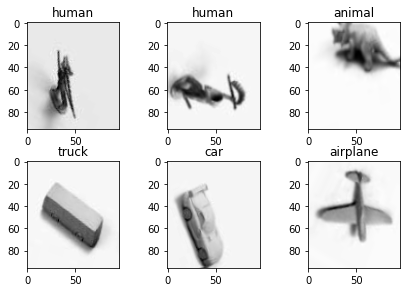

In [7]:
fig, axs = plt.subplots(2,3)
fig.tight_layout()
cls_ind = 0
for i in range(2):
    for j in range(3):
        test_sample,cls = train_dataset.__getitem__(190*cls_ind)
        axs[i][j].imshow(test_sample[0,:],cmap='gray', aspect='auto')
        axs[i][j].set_title(classes[cls])
        cls_ind+=1
plt.show()

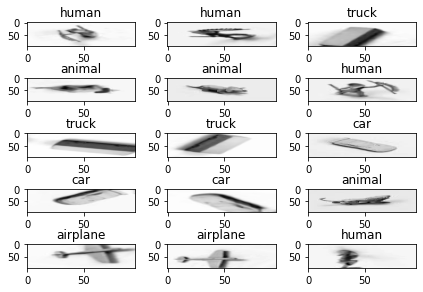

In [8]:
#Triplet Visualization

train_dataset_triplet = vdataset(train_df,triplet=True, transform = train_transform)


train_dataloader_triplet = DataLoader(train_dataset_triplet, batch_size=8*4,
                        shuffle=True, num_workers=32)

val_dataloader_triplet = DataLoader(val_dataset, batch_size=8*4,
                        shuffle=False, num_workers=32)

fig, axs = plt.subplots(5, 3)
fig.tight_layout()
cls_ind = 0
for i in range(5):

    (anc,cls),(pos,cls),(neg,neg_cls) = train_dataset_triplet.__getitem__(197*i+1)
    axs[i][0].imshow(anc[0,:],cmap='gray',aspect='auto')
    axs[i][0].set_title(classes[cls])
    axs[i][1].imshow(pos[0,:],cmap='gray', aspect='auto')
    axs[i][1].set_title(classes[cls])
    axs[i][2].imshow(neg[0,:],cmap='gray', aspect='auto')
    axs[i][2].set_title(classes[neg_cls])

plt.show()

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def conv_res(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class res_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(res_block, self).__init__()
        self.conv1 = conv_res(in_channels, out_channels, stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv_res(out_channels, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.relu(self.bn(self.conv1(x)))
        out = self.bn1(self.conv2(out))
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class res_net(nn.Module):
    def __init__(self, block, layers, triplet=False, num_classes=10):
        super(res_net, self).__init__()
        self.in_channels = 16
        self.triplet = triplet
        self.conv = conv_res(3, 8)
        self.conv1 = conv_res(8, 16)
        self.bn = nn.BatchNorm2d(8)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.rep_layer(block, 16, layers[0])
        self.layer2 = self.rep_layer(block, 32, layers[1], 2)
        self.layer3 = self.rep_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc1 = nn.Linear(576, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.sigmoid = nn.Sigmoid()

        
    def rep_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv_res(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward_pass(self,x):
        out = self.relu(self.bn(self.conv(x)))
        out = self.relu(self.bn1(self.conv1(out)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out
    
#     def dual_pass(self, x1, x2):
#         return self.sigmoid(self.forward_pass(x1)), self.sigmoid(self.forward_pass(x2))
        
    def forward(self, x):
       
        if self.triplet:

            return self.forward_pass(x)
        
        else:
            out = self.relu(self.forward_pass(x))
            return self.fc2(out)
        
    
resnet = res_net(res_block, [4, 16, 16*2], triplet=True, num_classes=len(classes))

from torchsummary import summary
summary(resnet,(3,96,96))



Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 96, 96]           216
├─BatchNorm2d: 1-2                       [-1, 8, 96, 96]           16
├─ReLU: 1-3                              [-1, 8, 96, 96]           --
├─Conv2d: 1-4                            [-1, 16, 96, 96]          1,152
├─BatchNorm2d: 1-5                       [-1, 16, 96, 96]          32
├─ReLU: 1-6                              [-1, 16, 96, 96]          --
├─Sequential: 1-7                        [-1, 16, 96, 96]          --
|    └─res_block: 2-1                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 96, 96]          32
|    |    └─ReLU: 3-3                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 96, 96]          32
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 8, 96, 96]           216
├─BatchNorm2d: 1-2                       [-1, 8, 96, 96]           16
├─ReLU: 1-3                              [-1, 8, 96, 96]           --
├─Conv2d: 1-4                            [-1, 16, 96, 96]          1,152
├─BatchNorm2d: 1-5                       [-1, 16, 96, 96]          32
├─ReLU: 1-6                              [-1, 16, 96, 96]          --
├─Sequential: 1-7                        [-1, 16, 96, 96]          --
|    └─res_block: 2-1                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-2             [-1, 16, 96, 96]          32
|    |    └─ReLU: 3-3                    [-1, 16, 96, 96]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 96, 96]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 96, 96]          32
|    

In [12]:
# !pip install timm

import timm
eff = timm.create_model('tf_efficientnet_b7_ns',  pretrained=False)
summary(eff,(3,96,96))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 64, 48, 48]          1,728
├─BatchNorm2d: 1-2                            [-1, 64, 48, 48]          128
├─SiLU: 1-3                                   [-1, 64, 48, 48]          --
├─Sequential: 1-4                             [-1, 640, 3, 3]           --
|    └─Sequential: 2-1                        [-1, 32, 48, 48]          --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 32, 48, 48]          4,944
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 32, 48, 48]          1,992
|    |    └─DepthwiseSeparableConv: 3-3       [-1, 32, 48, 48]          1,992
|    |    └─DepthwiseSeparableConv: 3-4       [-1, 32, 48, 48]          1,992
|    └─Sequential: 2-2                        [-1, 48, 24, 24]          --
|    |    └─InvertedResidual: 3-5             [-1, 48, 24, 24]          21,224
|    |    └─InvertedResidual: 3-6             [-1, 48, 24, 24]          38,

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 64, 48, 48]          1,728
├─BatchNorm2d: 1-2                            [-1, 64, 48, 48]          128
├─SiLU: 1-3                                   [-1, 64, 48, 48]          --
├─Sequential: 1-4                             [-1, 640, 3, 3]           --
|    └─Sequential: 2-1                        [-1, 32, 48, 48]          --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 32, 48, 48]          4,944
|    |    └─DepthwiseSeparableConv: 3-2       [-1, 32, 48, 48]          1,992
|    |    └─DepthwiseSeparableConv: 3-3       [-1, 32, 48, 48]          1,992
|    |    └─DepthwiseSeparableConv: 3-4       [-1, 32, 48, 48]          1,992
|    └─Sequential: 2-2                        [-1, 48, 24, 24]          --
|    |    └─InvertedResidual: 3-5             [-1, 48, 24, 24]          21,224
|    |    └─InvertedResidual: 3-6             [-1, 48, 24, 24]          38,

In [19]:
checkpoint_callback = ModelCheckpoint(
        monitor='valid_acc',
        mode = 'max',
        save_last=True,
        dirpath='weights/eff',
        filename='CE_loss-{epoch:02d}-{valid_acc:.2f}'
    )



class Net(pl.LightningModule):
    def __init__(self, model, triplet=False):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy()
        self.triplet = triplet
        self.triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
        self.fc2 = nn.Linear(1000, 5)
        self.alpha = 1
        self.gamma = 2

    def forward(self, x1, x2=None):
        if self.triplet:
            embedding1 = self.model(x1)
            embedding2 = self.model(x2)
            return embedding1, embedding2
        
        else:

            embedding = self.model(x1)
            return embedding

    def configure_optimizers(self):
        self.optimizer = SWA(torch.optim.Adam(self.model.parameters(),  lr=1e-8))
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer,
                                                                    T_max=10,
                                                                    eta_min=1e-2,
                                                                    verbose=True)

        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

    def training_step(self, train_batch, batch_idx):
        if self.triplet:
            (anc,lab_anc),(pos,lab_pos),(neg,lab_neg) = train_batch
        
            z_anc = self.model(anc)
            z_pos = self.model(pos)
            z_neg = self.model(neg)
            z = self.fc2(z_anc)
            
            CE_loss = F.cross_entropy(z,lab_anc)
#             pt = torch.exp(-CE_loss)
#             F_loss = self.alpha * (1-pt)**self.gamma * CE_loss
            
            loss = self.triplet_loss(z_anc, z_pos, z_neg) + CE_loss
            acc = self.accuracy(z, lab_anc)
            logs = {'train_loss': loss,'train_acc':acc , 'lr': self.optimizer.param_groups[0]['lr']}
            self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            return loss

        
        else:
            x, y = train_batch
            z = self.model(x)   
            z = self.fc2(z)
            loss = F.cross_entropy(z,y)
            acc = self.accuracy(z, y)
            logs = {'train_loss': loss, 'train_acc': acc, 'lr': self.optimizer.param_groups[0]['lr']}
            self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            return loss

    def validation_step(self, val_batch, batch_idx):

            x, y = val_batch
            z = self.model(x)
            z = self.fc2(z)
            loss = F.cross_entropy(z, y)
            acc = self.accuracy(z, y)
            logs = {'valid_loss': loss, 'valid_acc': acc}
            self.log_dict(logs, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            return loss
  
    def training_epoch_end(self, outs):
        self.log('train_acc_epoch', self.accuracy.compute())

# model
model = Net(eff, triplet=False)

# training
trainer = pl.Trainer(gpus=1,precision=16, max_epochs=400, callbacks=[checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)
    


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name         | Type              | Params
---------------------------------------------------
0 | model        | EfficientNet      | 66.3 M
1 | accuracy     | Accuracy          | 0     
2 | triplet_loss | TripletMarginLoss | 0     
3 | fc2          | Linear            | 5.0 K 
---------------------------------------------------
66.4 M    Trainable params
0         Non-trainable params
66.4 M    Total params
265.412   Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-08.


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.4473e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5492e-04.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.7553e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.0451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.9389e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5451e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.4549e-03.


Validating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.0611e-03.


Validating: 0it [00:00, ?it/s]